## Minor Project
### Crowd Classification using Deep Learning, Computer Vision and Decision Tree
### Guide: Dr. Sunil Kumar
### Students: Ananya Agrawal (199303010) & Hardik Srivastava (199303069)

## Part 1: Training a CNN Model to create crowd heatmap

Handling Imports

In [49]:
import tensorflow.keras
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, Concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import sys
import cv2
import keras.backend as K
import math
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

Setting up path variables

In [50]:
dataset = "B"
train_path = './data/formatted_trainval/shanghaitech_part_' + dataset + '_patches_9/train/'
train_den_path = './data/formatted_trainval/shanghaitech_part_' + dataset + '_patches_9/train_den/'
val_path = './data/formatted_trainval/shanghaitech_part_' + dataset + '_patches_9/val/'
val_den_path = './data/formatted_trainval/shanghaitech_part_' + dataset + '_patches_9/val_den/'
test_path = './data/original/shanghaitech/part_' + dataset + '_final/test_data/images/'
test_den_path = './data/original/shanghaitech/part_' + dataset + '_final/test_data/ground_truth_csv/'

Load Training Data

In [51]:
training_images = os.listdir(train_path)
num_training_images = len(training_images)

train_data = []
for i in range(num_training_images):
    if i % 100 == 0:
        print(i, '/', num_training_images, "Loaded")
    name = training_images[i]
    img = cv2.imread(train_path + name, 0)
    img = np.array(img)
    img = (img - 127.5) / 128
    den = np.loadtxt(open(train_den_path + name[:-4] + '.csv'), delimiter = ",")
    den_quarter = np.zeros((int(den.shape[0] / 4), int(den.shape[1] / 4)))
    for i in range(len(den_quarter)):
        for j in range(len(den_quarter[0])):
            for p in range(4):
                for q in range(4):
                    den_quarter[i][j] += den[i * 4 + p][j * 4 + q]
    train_data.append([img, den_quarter])
print('Training Data Loaded')

0 / 3249 Loaded
100 / 3249 Loaded
200 / 3249 Loaded
300 / 3249 Loaded
400 / 3249 Loaded
500 / 3249 Loaded
600 / 3249 Loaded
700 / 3249 Loaded
800 / 3249 Loaded
900 / 3249 Loaded
1000 / 3249 Loaded
1100 / 3249 Loaded
1200 / 3249 Loaded
1300 / 3249 Loaded
1400 / 3249 Loaded
1500 / 3249 Loaded
1600 / 3249 Loaded
1700 / 3249 Loaded
1800 / 3249 Loaded
1900 / 3249 Loaded
2000 / 3249 Loaded
2100 / 3249 Loaded
2200 / 3249 Loaded
2300 / 3249 Loaded
2400 / 3249 Loaded
2500 / 3249 Loaded
2600 / 3249 Loaded
2700 / 3249 Loaded
2800 / 3249 Loaded
2900 / 3249 Loaded
3000 / 3249 Loaded
3100 / 3249 Loaded
3200 / 3249 Loaded
Training Data Loaded


Loading Test Data

In [52]:
test_images = os.listdir(test_path)
num_test_images = len(test_images)

test_data = []
for i in range(num_test_images):
    if i % 50 == 0:
        print(i, '/', num_test_images)
    name = 'IMG_' + str(i + 1) + '.jpg'
    img = cv2.imread(test_path + name, 0)
    img = np.array(img)
    img = (img - 127.5) / 128
    den = np.loadtxt(open(test_den_path + name[:-4] + '.csv'), delimiter = ",")
    den_quarter = np.zeros((int(den.shape[0] / 4), int(den.shape[1] / 4)))
    for i in range(len(den_quarter)):
        for j in range(len(den_quarter[0])):
            for p in range(4):
                for q in range(4):
                    den_quarter[i][j] += den[i * 4 + p][j * 4 + q]
    test_data.append([img, den_quarter])
        
print('Test data Loaded')

0 / 316
50 / 316
100 / 316
150 / 316
200 / 316
250 / 316
300 / 316
Test data Loaded


Shuffling data around

In [53]:
np.random.shuffle(train_data)

Generate X, Y training and testing data lists

In [54]:
X_train = []
y_train = []

for d in train_data:
    X_train.append(np.reshape(d[0], (d[0].shape[0], d[0].shape[1], 1)))
    y_train.append(np.reshape(d[1], (d[1].shape[0], d[1].shape[1], 1)))

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []

for d in test_data:
    X_test.append(np.reshape(d[0], (d[0].shape[0], d[0].shape[1], 1)))
    y_test.append(np.reshape(d[1], (d[1].shape[0], d[1].shape[1], 1)))
X_test = np.array(X_test)
y_test = np.array(y_test)

Setup helper methods to calculate Mean Absolute Error, Mean Squared Error

In [55]:
def calc_mae(y_real, y_pred):
    return abs(K.sum(y_real) - K.sum(y_pred))

def calc_mse(y_real, y_pred):
    return ((K.sum(y_real) - K.sum(y_pred)) * (K.sum(y_real) - K.sum(y_pred)))

Setting up Model Architecture

In [56]:
inputs = Input(shape = (None, None, 1))
conv_m = Conv2D(20, (7, 7), padding = 'same', activation = 'relu')(inputs)
conv_m = MaxPooling2D(pool_size = (2, 2))(conv_m)
conv_m = (conv_m)
conv_m = Conv2D(40, (5, 5), padding = 'same', activation = 'relu')(conv_m)
conv_m = MaxPooling2D(pool_size = (2, 2))(conv_m)
conv_m = Conv2D(20, (5, 5), padding = 'same', activation = 'relu')(conv_m)
conv_m = Conv2D(10, (5, 5), padding = 'same', activation = 'relu')(conv_m)
#conv_m = Conv2D(1, (1, 1), padding = 'same', activation = 'relu')(conv_m)

conv_s = Conv2D(24, (5, 5), padding = 'same', activation = 'relu')(inputs)
conv_s = MaxPooling2D(pool_size = (2, 2))(conv_s)
conv_s = (conv_s)
conv_s = Conv2D(48, (3, 3), padding = 'same', activation = 'relu')(conv_s)
conv_s = MaxPooling2D(pool_size = (2, 2))(conv_s)
conv_s = Conv2D(24, (3, 3), padding = 'same', activation = 'relu')(conv_s)
conv_s = Conv2D(12, (3, 3), padding = 'same', activation = 'relu')(conv_s)
#conv_s = Conv2D(1, (1, 1), padding = 'same', activation = 'relu')(conv_s)

conv_l = Conv2D(16, (9, 9), padding = 'same', activation = 'relu')(inputs)
conv_l = MaxPooling2D(pool_size = (2, 2))(conv_l)
conv_l = (conv_l)
conv_l = Conv2D(32, (7, 7), padding = 'same', activation = 'relu')(conv_l)
conv_l = MaxPooling2D(pool_size = (2, 2))(conv_l)
conv_l = Conv2D(16, (7, 7), padding = 'same', activation = 'relu')(conv_l)
conv_l = Conv2D(8, (7, 7), padding = 'same', activation = 'relu')(conv_l)
#conv_l = Conv2D(1, (1, 1), padding = 'same', activation = 'relu')(conv_l)

conv_merge = Concatenate(axis = 3)([conv_m, conv_s, conv_l])
result = Conv2D(1, (1, 1), padding = 'same')(conv_merge)

model = Model(inputs = inputs, outputs = result)

adam = Adam(lr = 1e-4)
model.compile(loss = 'mse', optimizer = adam, metrics = [calc_mae, calc_mse])

Traing model (while occasionally saving model and weights to disk for checkpointing)

In [62]:
best_mae = 10000
best_mae_mse = 10000
best_mse = 10000
best_mse_mae = 10000

for i in range(200):
    model.fit(X_train, y_train, epochs = 3, batch_size = 1, validation_split = 0.2)

    score = model.evaluate(X_test, y_test, batch_size = 1)
    score[2] = math.sqrt(score[2])
    print(score)
    if score[1] < best_mae:
        best_mae = score[1]
        best_mae_mse = score[2]
        json_string = model.to_json()
        open('./model/model.json', 'w').write(json_string)
        model.save_weights('./model/weights.h5')
    if score[2] < best_mse:
        best_mse = score[2]
        best_mse_mae = score[1]

    print('Best mae: ', best_mae, '(', best_mae_mse, ')')
    print('Best mse: ', '(', best_mse_mae, ')', best_mse)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

Testing our trained model

In [64]:
mae = 0
mse = 0
for d in test_data:
    inputs = np.reshape(d[0], [1, 768, 1024, 1])
    outputs = model.predict(inputs)
    den = d[1]
    c_act = np.sum(den)
    c_pre = np.sum(outputs)
    print('pre:', c_pre, 'act:', c_act)
    mae += abs(c_pre - c_act)
    mse += (c_pre - c_act) * (c_pre - c_act)
mae /= len(test_data)
mse /= len(test_data)
mse = math.sqrt(mse)

print('#############################')
print('Mean Average Error:', mae, 'Mean Squared Error:', mse)

pre: 50.05846 act: 22.999919440000003
pre: 78.27924 act: 51.99981299000001
pre: 55.08571 act: 60.99978131
pre: 98.85934 act: 94.99966968
pre: 78.11312 act: 81.99971327
pre: 234.81802 act: 194.99936178
pre: 73.08304 act: 46.9998414
pre: 78.50609 act: 61.999782460000006
pre: 67.61428 act: 35.999864679999995
pre: 159.40231 act: 180.9995015
pre: 154.69278 act: 163.99951962000003
pre: 299.85892 act: 512.99923327
pre: 119.206856 act: 47.99983909000001
pre: 48.65071 act: 28.99989352
pre: 46.561386 act: 56.9998435
pre: 136.98163 act: 91.99968106
pre: 133.60475 act: 70.99975507
pre: 194.47652 act: 234.99958629000002
pre: 236.33563 act: 276.99926045999996
pre: 32.081306 act: 14.999945680000002
pre: 130.82207 act: 88.9997078
pre: 249.8396 act: 299.99932535000005
pre: 192.62509 act: 239.99959932
pre: 101.131096 act: 78.99973276
pre: 169.46799 act: 215.99959055999997
pre: 59.212532 act: 37.999865060000005
pre: 158.29951 act: 206.99933641000004
pre: 59.70992 act: 60.999790440000005
pre: 121.12582 ac

==================

## Part 2: Generating CSV dataset for training a Decision Tree Classifier for classifying images into Sparse, Medium, Dense

Setting source data directory, along with classes and other variables

In [14]:
source_dir = "./data_subset"
classes = ["dense", "medium", "sparse"]

Handling imports

In [15]:
import numpy as np
import pandas as pd
from mat4py import loadmat
from sklearn.cluster import KMeans
import os
import math

Defining methods to handle clustering logic

In [16]:
K_CONSTANT = 5

In [17]:
# imgnum, ab, ac, ad, ae, bc, bd, be, cd, ce, de, target
IMG_NUM = []
SOURCE_DATASET = []
AB = []
AC = []
AD = []
AE = []
BC = []
BD = []
BE = []
CD = []
CE = []
DE = []
TARGET = []

In [18]:
# reads mat file and returns formatted list of points in it
def read_pts(file):
    data = loadmat(file)
    pts = []
    for loc in data['image_info']['location']:
        pts.append((int(loc[0]), int(loc[1])))
    return pts

# creates clusters of pts list
def make_clusters(pts):
    est = KMeans(K_CONSTANT)
    est.fit(pts)
    y_kmeans = est.predict(pts)
    # cluster list
    cluster_list = [[], [], [], [], []]
    for index in range(len(pts)):
        cluster_list[y_kmeans[index]].append(pts[index])
    return cluster_list

# returns dist between 2 points
def pt_dist(p1, p2):
    xx = p1[0] - p2[0]
    yy = p1[1] - p2[1]
    return math.sqrt(xx*xx + yy*yy)

# returns min dist between cluster 1 and cluster 2
def min_dist(c1, c2):
    min = 9999999
    for p1 in c1:
        for p2 in c2:
            d = pt_dist(p1, p2)
            if min > d:
                min = d
    return min

def handle_class(classname, source_dataset):
    files = os.listdir(source_dir + "/" + classname)
    for file in files:
        if file.endswith(".mat"):
            imgname = str(file)[7:-4]
            IMG_NUM.append(imgname)
            SOURCE_DATASET.append(source_dataset)
            TARGET.append(classname)
            all_clusters = make_clusters(read_pts(source_dir + "/" + classname + "/" + file))
            AB.append(min_dist(all_clusters[0], all_clusters[1]))
            AC.append(min_dist(all_clusters[0], all_clusters[2]))
            AD.append(min_dist(all_clusters[0], all_clusters[3]))
            AE.append(min_dist(all_clusters[0], all_clusters[4]))
            BC.append(min_dist(all_clusters[1], all_clusters[2]))
            BD.append(min_dist(all_clusters[1], all_clusters[3]))
            BE.append(min_dist(all_clusters[1], all_clusters[4]))
            CD.append(min_dist(all_clusters[2], all_clusters[3]))
            CE.append(min_dist(all_clusters[2], all_clusters[4]))
            DE.append(min_dist(all_clusters[3], all_clusters[4]))


handle_class(classes[0], "A")
handle_class(classes[1], "B")
handle_class(classes[2], "B")

dataset = pd.DataFrame()
dataset["IMG_NUM"] = IMG_NUM
dataset["SOURCE_DATASET"] = SOURCE_DATASET
dataset["AB"] = AB
dataset["AC"] = AC
dataset["AD"] = AD
dataset["AE"] = AE
dataset["BC"] = BC
dataset["BD"] = BD
dataset["BE"] = BE
dataset["CD"] = CD
dataset["CE"] = CE
dataset["DE"] = DE
dataset["TARGET"] = TARGET
display(dataset)

,IMG_NUM,SOURCE_DATASET,AB,AC,AD,AE,BC,BD,BE,CD,CE,DE,TARGET
0,378,A,302.828334,16.643317,37.483330,243.895469,557.314992,21.095023,728.715308,290.241279,294.183616,493.852205,dense
1,392,A,281.016014,40.718546,708.968970,520.923219,20.880613,314.493243,32.695565,551.417265,266.317480,140.911320,dense
2,19,A,170.695636,2.828427,331.295940,6.000000,6.082763,5.000000,359.168484,162.265215,193.256306,510.553621,dense
3,30,A,495.009091,225.000000,6.000000,366.946863,7.071068,265.318676,34.928498,15.000000,36.687873,86.145226,dense
4,34,A,52.801515,387.881425,14.142136,20.124612,10.630146,18.110770,236.281612,266.317480,517.467873,9.000000,dense
5,395,A,98.061205,377.690349,72.138755,553.564811,41.303753,112.004464,444.567205,521.921450,779.133493,272.442655,dense
6,154,A,203.629566,29.000000,7.280110,6.708204,151.462867,379.296718,3.000000,69.971423,37.121422,180.113853,dense
7,21,A,359.560843,38.013156,69.462220,47.707442,358.803567,41.868843,17.000000,262.390930,25.317978,47.381431,dense
8,23,A,205.847031,240.010416,15.811388,26.925824,101.118742,49.040799,62.008064,227.070474,54.037024,49.929951,dense
9,37,A,280.349782,18.357560,49.193496,250.059993,19.104973,158.902486,40.311289,38.078866,47.853944,35.902646,dense


In [19]:
dataset.to_csv("./model/exported.csv")

=============================

## Part 3: Using the CSV dataset for training a Decision Tree Classifier for classifying images into Sparse, Medium, Dense

Handling Imports

In [20]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

Loading Data from CSV

In [21]:
cluster_data = pd.read_csv("./model/exported.csv", index_col=0)
cluster_data.head()

,IMG_NUM,SOURCE_DATASET,AB,AC,AD,AE,BC,BD,BE,CD,CE,DE,TARGET
0,378,A,302.828334,16.643317,37.483330,243.895469,557.314992,21.095023,728.715308,290.241279,294.183616,493.852205,dense
1,392,A,281.016014,40.718546,708.968970,520.923219,20.880613,314.493243,32.695565,551.417265,266.317480,140.911320,dense
2,19,A,170.695636,2.828427,331.295940,6.000000,6.082763,5.000000,359.168484,162.265215,193.256306,510.553621,dense
3,30,A,495.009091,225.000000,6.000000,366.946863,7.071068,265.318676,34.928498,15.000000,36.687873,86.145226,dense
4,34,A,52.801515,387.881425,14.142136,20.124612,10.630146,18.110770,236.281612,266.317480,517.467873,9.000000,dense


Preparing X and Y slices of data, where X is our source data and Y contains the Target Class

In [22]:
X = cluster_data.values[:, 2:-1]
Y = cluster_data.values[:, -1]

Splitting data into Train and Test

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

Setting up functions to create decision tree

In [24]:
# Function to perform training with giniIndex.
def train_using_gini(X_train, X_test, y_train):
    # Creating the classifier object
    clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=None)
    # Performing training
    clf_gini.fit(X_train, y_train)
    return clf_gini

# Function to make predictions
def prediction(X_test, clf_object):  
    # Predicton on test with giniIndex
    y_pred = clf_object.predict(X_test)
    print("Predicted values:")
    print(y_pred)
    return y_pred

# Function to calculate accuracy
def cal_accuracy(y_test, y_pred):      
    print("Confusion Matrix: ", confusion_matrix(y_test, y_pred))
    print ("Accuracy : ", accuracy_score(y_test,y_pred) * 100)
    print("Report : ", classification_report(y_test, y_pred))

In [25]:
clf_gini = train_using_gini(X_train, X_test, y_train)

y_pred_gini = prediction(X_test, clf_gini)
cal_accuracy(y_test, y_pred_gini)

Predicted values:
['dense' 'medium' 'sparse' 'sparse' 'dense' 'dense' 'sparse' 'dense'
 'sparse' 'medium' 'medium' 'sparse']
Confusion Matrix:  [[1 1 0]
 [1 1 1]
 [2 1 4]]
Accuracy :  50.0
Report :                precision    recall  f1-score   support

       dense       0.25      0.50      0.33         2
      medium       0.33      0.33      0.33         3
      sparse       0.80      0.57      0.67         7

    accuracy                           0.50        12
   macro avg       0.46      0.47      0.44        12
weighted avg       0.59      0.50      0.53        12



======================================

## Part 4: Using the trained model to generate heatmaps for a provided crowd image

Handling Imports

In [26]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import os
import random
import math
import sys
from pyheatmap.heatmap import HeatMap
from PIL import Image

Loading Model and Weights from disk

In [61]:
json_file = open('./model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = keras.models.model_from_json(loaded_model_json)

model.load_weights("./model/weights.h5")

print("Loaded model from disk successfully")

Loaded model from disk successfully


Setting up path of input image

In [35]:
input_image = "/Users/hardik/Projects/Minor/minor-new/data/original/shanghaitech/part_B_final/train_data/images/IMG_331.jpg"

Loading and preprocessing input image to correspond to input layer size

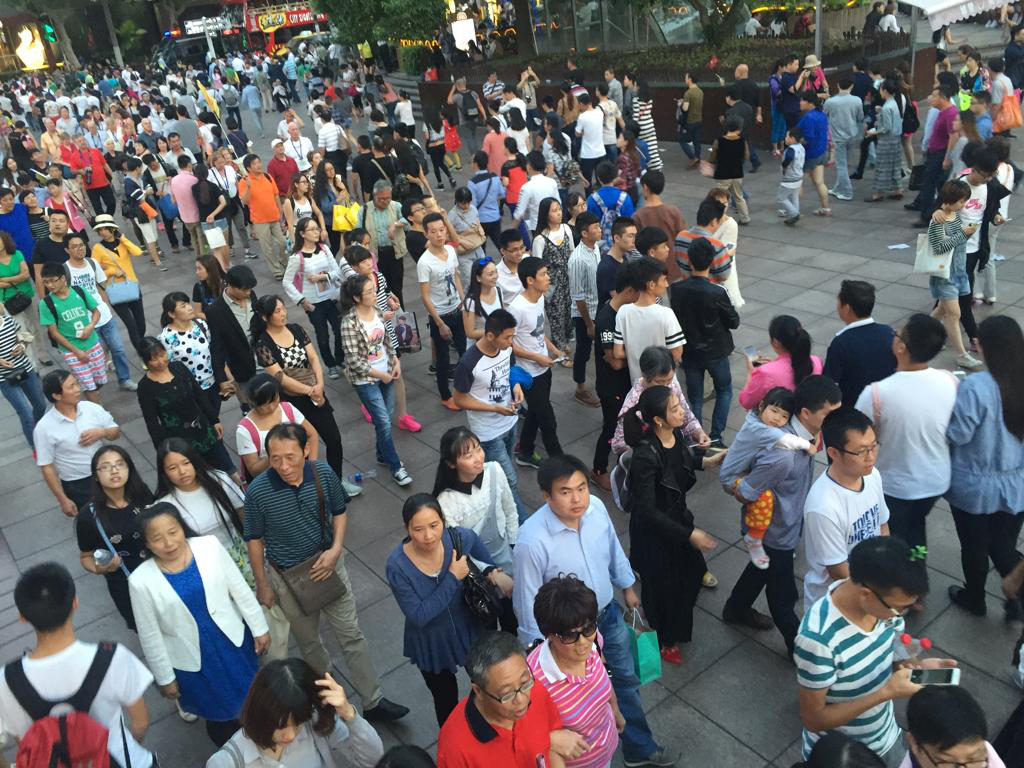

In [38]:
img = np.array(cv2.imread(input_image, 0))
img = (img - 127.5) / 128
inputs = np.reshape(img, [1, 768, 1024, 1])
display(Image.open(input_image))

Inferencing through model

In [39]:
outputs = model.predict(inputs)
predicted_count = np.sum(outputs)

Printing predicted count

In [40]:
print("Predicted Count:", predicted_count)

Predicted Count: 113.48088


Generating density numpy array

In [41]:
y_p_den = np.reshape(outputs, (outputs.shape[1], outputs.shape[2]))

Generating Heatmap

Heatmap Generated to output.png


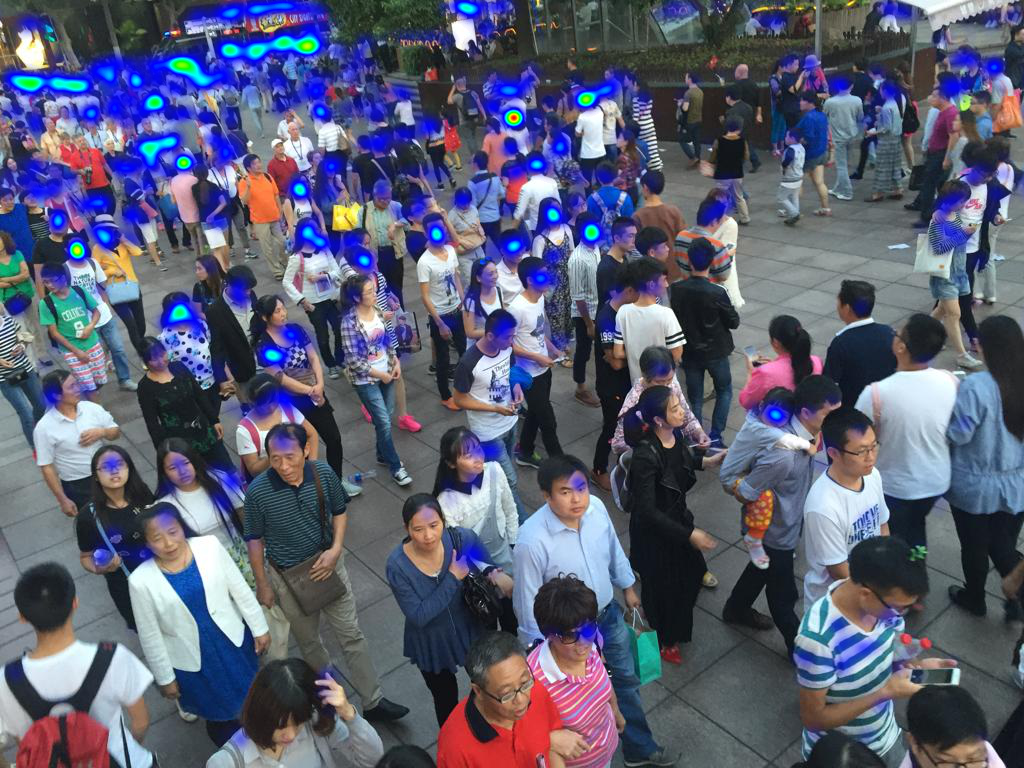

In [42]:
den_resized = np.zeros((y_p_den.shape[0] * 4, y_p_den.shape[1] * 4))
for i in range(den_resized.shape[0]):
    for j in range(den_resized.shape[1]):
        den_resized[i][j] = y_p_den[int(i / 4)][int(j / 4)] / 16
den = den_resized
count = np.sum(den)
den = den * 10 / np.max(den)

crowd_img = cv2.imread(input_image, 1)

data = []
pts = []

for j in range(len(den)):
    for i in range(len(den[0])):
        for k in range(int(den[j][i])):
            data.append([i + 1, j + 1])
            pts.append((i + 1, j + 1))

hm = HeatMap(data, base=input_image)
hm.heatmap(save_as = 'output.png')
print("Heatmap Generated to output.png")
display(Image.open("output.png"))

## Part 5: Finding group of cluster distances and running our inference through Decision Tree

Generate combination of distances for all clusters

In [43]:
all_clusters = make_clusters(pts)

ab = min_dist(all_clusters[0], all_clusters[1])
ac = min_dist(all_clusters[0], all_clusters[2])
ad = min_dist(all_clusters[0], all_clusters[3])
ae = min_dist(all_clusters[0], all_clusters[4])
bc = min_dist(all_clusters[1], all_clusters[2])
bd = min_dist(all_clusters[1], all_clusters[3])
be = min_dist(all_clusters[1], all_clusters[4])
cd = min_dist(all_clusters[2], all_clusters[3])
ce = min_dist(all_clusters[2], all_clusters[4])
de = min_dist(all_clusters[3], all_clusters[4])

Create entry and get prediction for our image

In [44]:
check_entry = [ab, ac, ad, ae, bc, bd, be, cd, ce, ce]
print(check_entry)

[1.0, 349.516809323958, 1.0, 334.18108863309425, 47.01063709417264, 1.0, 1.0, 10.295630140987, 1.0, 1.0]


In [45]:
y_pred_gini = prediction([check_entry], clf_gini)

Predicted values:
['dense']
